In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from scipy import signal
from pandasql import sqldf

# Treadmill data analysis
Quentin Decultot, JJ Aucouturier, 2021

In [29]:
# load examples 
file_1 = 'treadmill_1_21_05_06_14_24'
step_data_1 = pd.read_csv('data/'+file_1+'.csv')
sound_data_1 = pd.read_csv('data/'+file_1+'_sound.csv')

file_2 = 'treadmill_2_21_05_06_15_02'
step_data_2 = pd.read_csv('data/'+file_2+'.csv')
sound_data_2 = pd.read_csv('data/'+file_2+'_sound.csv')

c:\users\qdecu\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Debug

Quentin: this section lists potential issues found in the files, which should be fixed in the experimental code. 

### Time reset in file 1

File treadmill_1_21_05_06_14_24 has a pb. Headers ("time, x_left...") are inserted a second time at time = 5000, and time is reset to 0 after this position. 

In [4]:
print(step_data_1[pd.to_numeric(step_data_1.time, errors='coerce').isnull()])

      time  x_left  y_left  z_left  x_right  y_right  z_right
5000  time  x_left  y_left  z_left  x_right  y_right  z_right


In [5]:
step_data_1.loc[4995:5005]

,time,x_left,y_left,z_left,x_right,y_right,z_right
4995,4995.06422996521,0.3898674307220942,-0.591251647693392,-2.009833909870968,-3.0451940738555447,-1.2622521112901666,-0.3461191397861185
4996,4996.06422996521,0.38477409233570015,-0.591251647693392,-2.0072872129705015,-3.0401012309403206,-1.2622521112901666,-0.3461191397861185
4997,4997.06422996521,0.38477409233570015,-0.5887048981723968,-2.0072872129705015,-3.0350083880250964,-1.2622521112901666,-0.3461191397861185
4998,4998.06422996521,0.39241409991529164,-0.5887048981723968,-2.0072872129705015,-3.0401012309403206,-1.2622521112901666,-0.3461191397861185
4999,4999.06422996521,0.4000541074948831,-0.5887048981723968,-2.0047405160700347,-3.0426476523979327,-1.2622521112901666,-0.3461191397861185
5000,time,x_left,y_left,z_left,x_right,y_right,z_right
5001,0.0637972354888916,1.0723747744989174,-0.24234696331709582,0.45536868978057754,-3.1368652463295805,-1.3845040595644278,-0.2951743396600115
5002,1.0637972354888916,0.9756013451574272,-0.2576274604430644,0.4681021742829099,-3.3049290625319796,-1.3539410724958643,-0.3155522597104543
5003,2.0637972354888916,1.0367214057941574,-0.31874944894694135,0.45536868978057754,-3.1903400969394347,-1.272439773646358,-0.3257412197356757
5004,3.0637972354888916,0.9756013451574272,-0.34676369367788507,0.4349951145768465,-3.147050932160029,-1.272439773646358,-0.3155522597104543


This creates pb when plotting data (value 'time' in col time is not a numeric (have to coerce it into a Nan), and also uncertainty as to what time should be considered (start at 5000 ? Add 5000 to all values after 5000 ?)

(-1000.0, 6000.0)

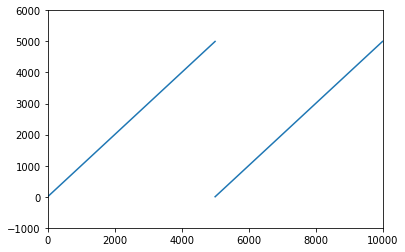

In [6]:
plt.plot(pd.to_numeric(step_data_1.time, errors='coerce'))
plt.xlim([0,10000])
plt.ylim([-1000,6000])

File treadmill_2_21_05_06_15_02 doesn't have the same problem

In [7]:
print(step_data_2[pd.to_numeric(step_data_2.time, errors='coerce').isnull()])

Empty DataFrame
Columns: [time, x_left, y_left, z_left, x_right, y_right, z_right]
Index: []


For now, simply delete data before 5000 in first file. 

In [31]:
step_data_1 = step_data_1.loc[5001:].reset_index()

In [9]:
print(step_data_1[pd.to_numeric(step_data_1.time, errors='coerce').isnull()])

Empty DataFrame
Columns: [index, time, x_left, y_left, z_left, x_right, y_right, z_right]
Index: []


## Step data analysis

The goal of this section is to segment step data corresponding to each trial/note, and to extract features from each step, resulting in a dataframe in the form of: 
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_feature</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>2.3</td>
  </tr>
  <tr>
    <td>1</td>
    <td>2</td>
    <td>Bb3</td>
    <td>0.6</td>
  </tr>
  <tr>
    <td>1</td>
    <td>...</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>1</td>
    <td>1500</td>
    <td>C#5</td>
    <td>1.8</td>
  </tr>
</tbody>
</table>

In [32]:
step_data_1 = step_data_1.apply(pd.to_numeric)
step_data_2 = step_data_2.apply(pd.to_numeric)


### Observations

#### Irregular step timing

Quentin & JJ do not have the same timing: JJ looks a lot more irregular than Quentin. We can't assume that the sound position gives the position of the step (e.g. can't for-loop in sounds to look in step data). \
<b>Strategy:</b> first find start and end of each step in step data(e.g. on z), then try to assign each step to a sound (e.g. if sound_time is in [step_start, step_stop]), possibly skip sound when there is ambiguity.

JJ:

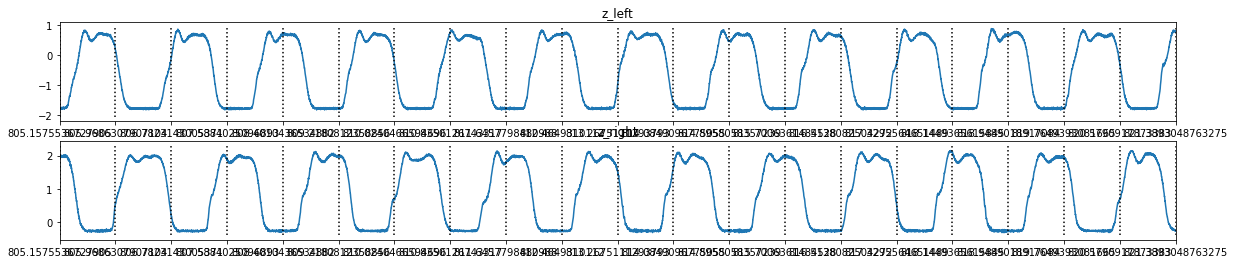

In [11]:
dims= ['z_left','z_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_1['time']/1000,step_data_1[dim])
    plt.title(dim)
    for id,row in sound_data_1.iterrows(): 
        plt.plot([row.time,row.time],[step_data_1[dim].min(),step_data_1[dim].max()],'k:')
    plt.xlim([1000,1020])


Quentin:

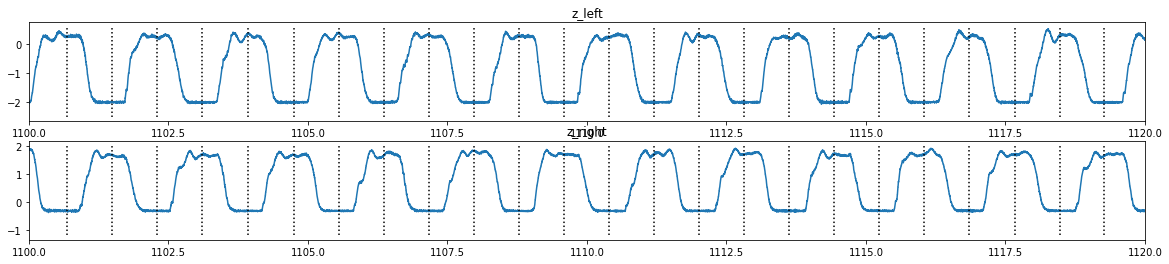

In [12]:
dims= ['z_left','z_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_2['time']/1000,step_data_2[dim])
    plt.title(dim)
    for id,row in sound_data_2.iterrows(): 
        plt.plot([row.time,row.time],[step_data_2[dim].min(),step_data_2[dim].max()],'k:')
    plt.xlim([1100,1120])


#### Step data easier to segment on z

Step data is a lot easier to segment on z_left and z_right than  x,y. \
<b>Strategy:</b> find step start/stop on z, then apply to x,y (because same timing). Note also that Y_right more noisy than Y_left. 

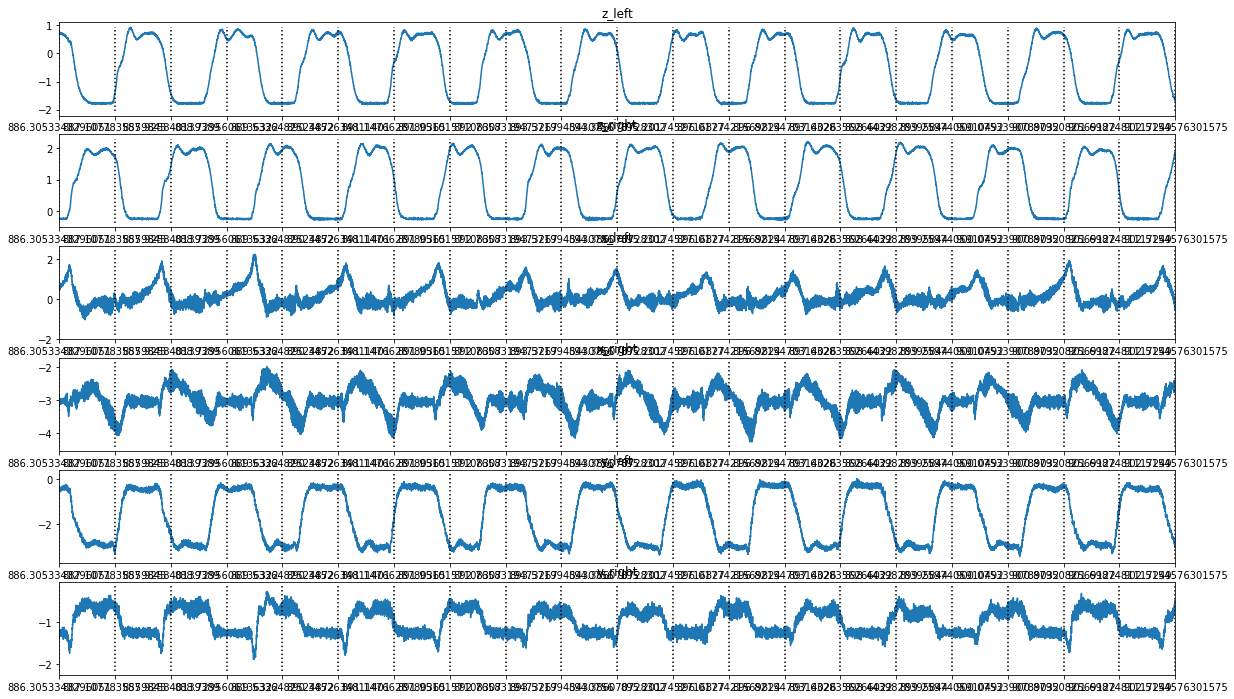

In [13]:
dims= ['z_left','z_right', 'x_left','x_right', 'y_left','y_right']
fig = plt.figure(figsize=(20,2*len(dims)))
for index, dim in enumerate(dims): 
    ax = fig.add_subplot(len(dims),1,index+1)
    plt.plot(step_data_1['time']/1000,step_data_1[dim])
    #plt.plot(step_data_1['time']/1000,step_data_1[dim])
    
    plt.title(dim)
    for id,row in sound_data_1.iterrows(): 
        plt.plot([row.time,row.time],[step_data_1[dim].min(),step_data_1[dim].max()],'k:')
    plt.xlim([1100,1120])


#### Resampling

Note: estimated sample rate = 1000Hz

In [14]:
len(step_data_1.time)/(step_data_1.time.max()/1000)

1000.0007719992473

In [8]:
sr = 1000

We wouldn't lose much by downsampling to 100Hz (10ms precision on the onset/duration of the step, possibly), and divide memory/cpu by 10. \
<b> Strategy: </b> For now, downsample in notebook. If this is confirmed, maybe sample at 100Hz during the experiment, and put sr in config file. 

Text(0.5, 1.0, '100Hz')

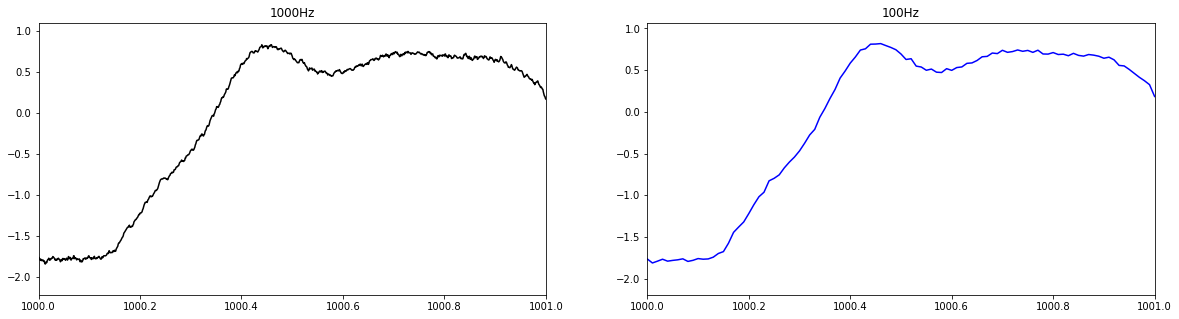

In [18]:
x = np.array(step_data_1['z_left'])
t = np.array(step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([1000, 1001])
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
new_sr = 100
(x,t)=signal.resample(x,t=t,num=int((len(x)/sr)*new_sr))
plt.plot(t/1000,x,'b')
plt.xlim([1000, 1001])
plt.title('%dHz'%new_sr)

#### Detrend

Z data has a trend, which makes using a fixed threshold to segment step impossible (min + 5% at the beginning is < min at the end)

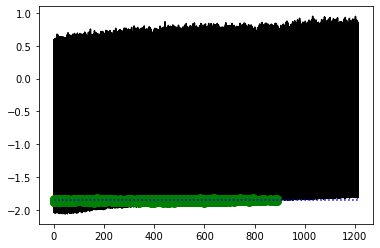

In [19]:
times= step_data_1.time
x = step_data_1.z_left

# adapt threshold to min + a percent of (range of x)
x_min = np.percentile(x,1) 
x_max = np.percentile(x,99)
percent_range = 0.05
threshold = x_min + (x_max-x_min)*percent_range
mask = np.diff(1 * (x > threshold) != 0)

plt.plot(times/1000, x, 'k')
plt.plot(times[:-1][mask]/1000,x[:-1][mask], 'go', markersize=8)
plt.plot([times.min()/1000,times.max()/1000],[threshold,threshold],'b:')
    

That trend is there for both dataset, so it's not a feature of the participant but a bug of the treadmill. \
<b> Strategy: </b> Detrend before analysis

### Preprocessing

#### Resample

Text(0.5, 1.0, '100Hz')

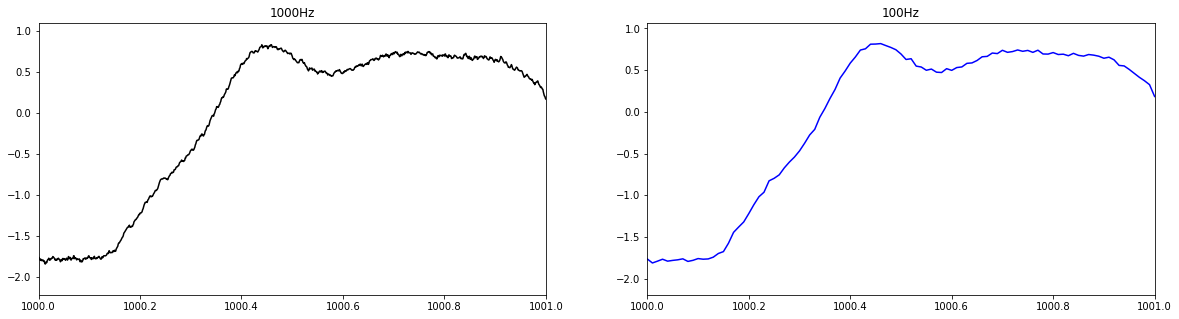

In [11]:
def resample_all_cols(df, sr, new_sr, time_col='time'): 
    # resample all cols except time_col to new_sr
    
    # list data columns (neither index nor time)
    data_cols = list(df)
    if time_col in data_cols:
        data_cols.remove(time_col)
    if 'index' in data_cols:
        data_cols.remove('index')
    
    resampled_df = pd.DataFrame()
    for data_col in data_cols: 
        data = np.array(df[data_col])
        time = np.array(df[time_col])
        (new_data,new_time) = signal.resample(data,
                                t=time,
                                num = int((len(data)/sr)*new_sr))
        resampled_df[data_col] = new_data
    resampled_df['time'] = new_time
    return resampled_df

# test
# resample to 100Hz
rs_step_data_1 = resample_all_cols(step_data_1,sr,100)
# plot original vs resampled 
x = np.array(step_data_1['z_left'])
t = np.array(step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([1000, 1001])
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
x = np.array(rs_step_data_1['z_left'])
t = np.array(rs_step_data_1['time'])
plt.plot(t/1000,x,'b')
plt.xlim([1000, 1001])
plt.title('%dHz'%100)

#### Detrend

Text(0.5, 1.0, '100Hz')

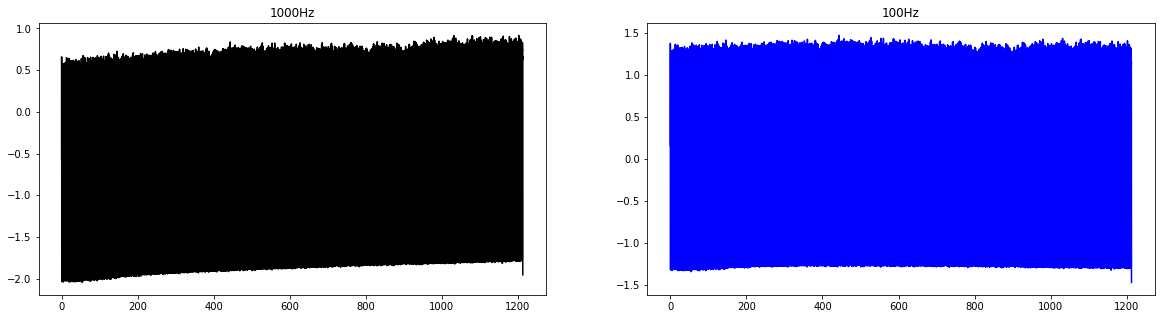

In [14]:
def detrend_all_cols(df,time_col='time'):
    # remove linear trend in data
    
    # list data columns (neither index nor time)
    data_cols = list(df)
    if time_col in data_cols:
        data_cols.remove(time_col)
    if 'index' in data_cols:
        data_cols.remove('index')
        
    detrend_df = pd.DataFrame()
    for data_col in data_cols: 
        detrend_df[data_col]=signal.detrend(np.array(df[data_col]),
                                             type='linear')
    detrend_df['time'] = df[time_col]
    return detrend_df

# test
rs_step_data_1 = resample_all_cols(step_data_1,sr,100)
de_step_data_1 = detrend_all_cols(rs_step_data_1)

x = np.array(rs_step_data_1['z_left'])
t = np.array(rs_step_data_1['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
x = np.array(de_step_data_1['z_left'])
t = np.array(de_step_data_1['time'])
plt.plot(t/1000,x,'b')
plt.title('%dHz'%100)
    

### Segmentation

The goal of this section is to segment step data corresponding to each trial/note, downsample it to a suitable sampling rate, and store it in a dataframe.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>step_data_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

(604.0, 606.0)

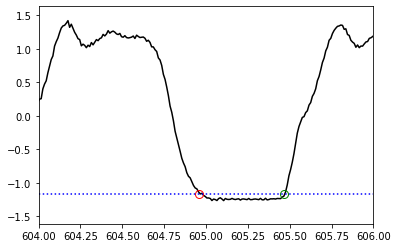

In [33]:
# find start and stop times for each step in time series x
# minduration in sec.
def segment_steps(times,x, min_duration):
    start_times = []
    end_times = []
    
    # adapt threshold to min + a percent of (range of x)
    x_min = np.percentile(x,1) 
    x_max = np.percentile(x,99)
    percent_range = 0.05
    threshold = x_min + (x_max-x_min)*percent_range
    
    # detect up and down crossings     
    mask = np.diff(1*(x > threshold)) # 1 if crosses threshold up, -1 if crosses down
    start_times = times[:-1][mask>0] 
    end_times = times[:-1][mask<0] 
    
    # drop potential endings that occur before first start
    end_times = [end_time for end_time in list(end_times) if end_time > list(start_times)[0]]
    # drop potential starts that occur after the last ending
    start_times = [start_time for start_time in list(start_times) if start_time < list(end_times)[-1]]
        
    # eliminate false alarms (ie. consecutive starts or stops within a short time window, ex. 0.1s)
    start_times, end_times = zip(*[(start_time,end_time) for start_time,end_time in zip(start_times,end_times) if (end_time-start_time) > (min_duration*1000)])
    
    return start_times, end_times, threshold

#test    
rs_step_data_1 = resample_all_cols(step_data_1,sr,100)
de_step_data_1 = detrend_all_cols(rs_step_data_1)

times = de_step_data_1.time
x = de_step_data_1.z_left
start_times, end_times, threshold = segment_steps(times,x, 0.1)
plt.plot(times/1000, x, 'k')
plt.plot(np.array(start_times)/1000,[threshold]*len(start_times), 'go', markersize=8, markerfacecolor='None')
plt.plot(np.array(end_times)/1000,[threshold]*len(end_times), 'ro', markersize=8, markerfacecolor='None')
plt.plot([times.min()/1000,times.max()/1000],[threshold,threshold],'b:')
plt.xlim([604,606])

### Step feature extraction

#### Dataframe steps

In [50]:
# create dataframe of steps

print("%d starts, %d ends"%(len(start_times),len(end_times)))

def df_creator(data):
    step_datas_z = []
    step_datas_x = []
    step_datas_y = []
    max_ampl_x = []
    max_ampl_y = []
    max_ampl_z = []
    step_sizes=[]
    step_foots = []

    #data from left feet
    start_times, end_times, threshold = segment_steps(data.time,data.z_left, 0.1)

    for start_time,end_time in zip(start_times,end_times): 
        #print("start:%.0f - end:%.0f; "%(start_time,end_time),end='')
        step_data_left_z = list(data[(data.time >=start_time)&(data.time <end_time)].z_left)
        step_data_left_x = list(data[(data.time >=start_time)&(data.time <end_time)].x_left)
        step_data_left_y = list(data[(data.time >=start_time)&(data.time <end_time)].y_left)
        max_amplitude_x = max(step_data_left_x)-min(step_data_left_x)
        max_amplitude_y = max(step_data_left_x)-min(step_data_left_y)
        max_amplitude_z = max(step_data_left_x)-min(step_data_left_z)
        step_datas_z.append(step_data_left_z)
        step_datas_x.append(step_data_left_x)
        step_datas_y.append(step_data_left_y)
        max_ampl_x.append(max_amplitude_x)
        max_ampl_y.append(max_amplitude_y)
        max_ampl_z.append(max_amplitude_z)
        step_foots.append('left')
        step_sizes.append(end_time-start_time)

    start = start_times
    end = end_times

    #data from right feet
    start_times, end_times, threshold = segment_steps(data.time,data.z_right, 0.1)    

    for start_time,end_time in zip(start_times,end_times): 
        #print("start:%.0f - end:%.0f; "%(start_time,end_time),end='')
        step_data_right_z = list(data[(data.time >=start_time)&(data.time <end_time)].z_right)
        step_data_right_x = list(data[(data.time >=start_time)&(data.time <end_time)].x_right)
        step_data_right_y = list(data[(data.time >=start_time)&(data.time <end_time)].y_right)
        max_amplitude_x = max(step_data_right_x)-min(step_data_right_x)
        max_amplitude_y = max(step_data_right_x)-min(step_data_right_y)
        max_amplitude_z = max(step_data_right_x)-min(step_data_right_z)
        step_datas_z.append(step_data_right_z)
        step_datas_x.append(step_data_right_x)
        step_datas_y.append(step_data_right_y)
        max_ampl_x.append(max_amplitude_x)
        max_ampl_y.append(max_amplitude_y)
        max_ampl_z.append(max_amplitude_z)
        step_foots.append('right')
        step_sizes.append(end_time-start_time)

    start += start_times
    end += end_times

    #creation of a global dataframe
    steps = pd.DataFrame({'start':start, 'end': end, 'step_data_z': step_datas_z, 'max_ampl_z':max_ampl_z,
                          'step_data_x': step_datas_x, 'max_ampl_x':max_ampl_x,
                          'step_data_y': step_datas_y, 'max_ampl_y':max_ampl_y,
                          'foot':step_foots, 'step_duration':step_sizes})
    steps.start = steps.start/1000
    steps.end = steps.end/1000
    steps.step_duration = steps.step_duration/1000

    #sorting of the dataframe on the column 'Start'
    steps = steps.sort_values('start', ascending=True)
    return steps

rs_step_data_1 = resample_all_cols(step_data_1,sr,100)
de_step_data_1 = detrend_all_cols(rs_step_data_1)
rs_step_data_2 = resample_all_cols(step_data_2,sr,100)
de_step_data_2 = detrend_all_cols(rs_step_data_2)
steps = df_creator(de_step_data_2)
steps


743 starts, 743 ends


,start,end,step_data_z,max_ampl_z,step_data_x,max_ampl_x,step_data_y,max_ampl_y,foot,step_duration
0,0.100099,1.200099,"[-1.1137354003813849, -1.0475766770679125, -0....",2.394483,"[-0.4052848148112963, -0.3593281825648025, -0....",2.100295,"[-1.2250302887336837, -1.2690286723900228, -1....",2.549776,left,1.10
753,0.960099,1.940099,"[-0.9771868912536466, -0.8908629238372452, -0....",1.709667,"[0.0038963172609269847, -0.23088366277964223, ...",1.416859,"[-0.22131478824380446, -0.2690658640421697, -0...",1.103686,right,0.98
1,1.730099,2.620099,"[-1.1009570810462483, -1.032928162555689, -0.9...",2.129963,"[-0.4670903395343956, -0.2850246653673135, 0.0...",1.762061,"[-1.2406914484584555, -1.2466538984854836, -1....",2.275660,left,0.89
754,2.430099,3.220099,"[-0.9959976037680349, -0.9430885089575785, -0....",1.540409,"[0.17540092419090314, 0.011832708078954646, -0...",1.093618,"[-0.2745138495220947, -0.3635525894023264, -0....",0.971275,right,0.79
2,3.030099,3.900099,"[-1.110938194495503, -1.0098738654973038, -0.8...",2.473795,"[-0.6369368495567289, -0.2122297689333754, 0.1...",2.108189,"[-1.192386844854867, -1.1398630610378773, -1.2...",2.687058,left,0.87
...,...,...,...,...,...,...,...,...,...,...
1503,1215.860099,1216.920099,"[-1.005369760695423, -0.9324373253188414, -0.8...",1.613588,"[0.039496919882958004, -0.18266686502198315, -...",1.674971,"[-0.323998672266671, -0.3081555975763659, -0.3...",1.250592,right,1.06
751,1216.680099,1217.710099,"[-1.099903475470907, -1.0091081060150344, -0.8...",2.599540,"[-0.57156608833043, -0.33794390543272446, -0.0...",2.219298,"[-1.2036556543823629, -1.214046786853192, -1.2...",2.762378,left,1.03
1504,1217.460099,1218.770099,"[-1.0095457395388667, -0.8620809383772954, -0....",1.947362,"[0.004278569953541478, -0.24429648702723572, -...",1.741769,"[-0.30785106971149934, -0.3735506332490426, -0...",1.491539,right,1.31
752,1218.440099,1222.720099,"[-1.0767584432464508, -0.9163095261395754, -0....",1.671511,"[-0.49894438161760624, -0.3035190583944217, -0...",2.092481,"[-1.1856025217809003, -1.1982451238527343, -1....",1.792998,left,4.28


#### Adaptation of the format

In [51]:
def dbGetQuery(q):
    return sqldf(q, globals())

# Selection of the needed columns for the join on trials (notes)
sound_data_2 = dbGetQuery("SELECT time,note,shift FROM sound_data_2")
sound_data_2

,time,note,shift
0,0.293367,D4,0
1,1.106996,Gb3,30
2,1.915570,C4,-20
3,2.727042,Eb4,-10
4,3.539465,A4,-10
...,...,...,...
1495,1212.334954,Eb4,-20
1496,1213.137915,Ab3,30
1497,1213.950592,G3,20
1498,1214.759762,D3,-30


In [52]:
#conversion of the column 'step_data' for the SQL operation
steps = steps.applymap(str)
steps
#observation : the next step is starting before the previous ends. It seems logical as the speed isn't too high

,start,end,step_data_z,max_ampl_z,step_data_x,max_ampl_x,step_data_y,max_ampl_y,foot,step_duration
0,0.10009884929656983,1.2000988492965698,"[-1.1137354003813849, -1.0475766770679125, -0....",2.3944830142841913,"[-0.4052848148112963, -0.3593281825648025, -0....",2.100295464349724,"[-1.2250302887336837, -1.2690286723900228, -1....",2.549776286292829,left,1.1
753,0.9600988492965699,1.9400988492965698,"[-0.9771868912536466, -0.8908629238372452, -0....",1.709667176784663,"[0.0038963172609269847, -0.23088366277964223, ...",1.4168592558051891,"[-0.22131478824380446, -0.2690658640421697, -0...",1.1036862192231882,right,0.98
1,1.7300988492965699,2.62009884929657,"[-1.1009570810462483, -1.032928162555689, -0.9...",2.129962789959368,"[-0.4670903395343956, -0.2850246653673135, 0.0...",1.762060764982175,"[-1.2406914484584555, -1.2466538984854836, -1....",2.2756596073986035,left,0.89
754,2.4300988492965696,3.2200988492965696,"[-0.9959976037680349, -0.9430885089575785, -0....",1.540409086423942,"[0.17540092419090314, 0.011832708078954646, -0...",1.0936180348610862,"[-0.2745138495220947, -0.3635525894023264, -0....",0.9712745573707215,right,0.79
2,3.0300988492965697,3.90009884929657,"[-1.110938194495503, -1.0098738654973038, -0.8...",2.473794524463866,"[-0.6369368495567289, -0.2122297689333754, 0.1...",2.1081888563501745,"[-1.192386844854867, -1.1398630610378773, -1.2...",2.6870580437641776,left,0.87
...,...,...,...,...,...,...,...,...,...,...
1503,1215.8600988492965,1216.9200988492967,"[-1.005369760695423, -0.9324373253188414, -0.8...",1.6135883902326644,"[0.039496919882958004, -0.18266686502198315, -...",1.674970895682406,"[-0.323998672266671, -0.3081555975763659, -0.3...",1.2505917437973835,right,1.06
751,1216.6800988492967,1217.7100988492966,"[-1.099903475470907, -1.0091081060150344, -0.8...",2.599540464549546,"[-0.57156608833043, -0.33794390543272446, -0.0...",2.2192982210863708,"[-1.2036556543823629, -1.214046786853192, -1.2...",2.762377960952927,left,1.03
1504,1217.4600988492966,1218.7700988492966,"[-1.0095457395388667, -0.8620809383772954, -0....",1.9473620621838794,"[0.004278569953541478, -0.24429648702723572, -...",1.7417693052530838,"[-0.30785106971149934, -0.3735506332490426, -0...",1.4915387598242293,right,1.31
752,1218.4400988492966,1222.7200988492966,"[-1.0767584432464508, -0.9163095261395754, -0....",1.6715113524962673,"[-0.49894438161760624, -0.3035190583944217, -0...",2.0924805536031212,"[-1.1856025217809003, -1.1982451238527343, -1....",1.7929980331025508,left,4.28


#### SQL query

In [53]:
query = """
SELECT
    steps.start
    , steps.end
    , steps.step_data_z
    , steps.max_ampl_z
    , steps.step_data_x
    , steps.max_ampl_x
    , steps.step_data_y
    , steps.max_ampl_y
    , steps.foot
    , steps.step_duration
    , sound_data_2.note AS note
    , sound_data_2.shift AS shift
    , sound_data_2.time AS time
FROM
    sound_data_2
INNER JOIN steps
    ON (sound_data_2.time >= steps.start AND sound_data_2.time < steps.end)
ORDER BY sound_data_2.time
"""

In [54]:
mixed_data = dbGetQuery(query)

In [55]:
mixed_data

,start,end,step_data_z,max_ampl_z,step_data_x,max_ampl_x,step_data_y,max_ampl_y,foot,step_duration,note,shift,time
0,0.10009884929656983,1.2000988492965698,"[-1.1137354003813849, -1.0475766770679125, -0....",2.3944830142841913,"[-0.4052848148112963, -0.3593281825648025, -0....",2.100295464349724,"[-1.2250302887336837, -1.2690286723900228, -1....",2.549776286292829,left,1.1,D4,0,0.293367
1,0.10009884929656983,1.2000988492965698,"[-1.1137354003813849, -1.0475766770679125, -0....",2.3944830142841913,"[-0.4052848148112963, -0.3593281825648025, -0....",2.100295464349724,"[-1.2250302887336837, -1.2690286723900228, -1....",2.549776286292829,left,1.1,Gb3,30,1.106996
2,0.9600988492965699,1.9400988492965698,"[-0.9771868912536466, -0.8908629238372452, -0....",1.709667176784663,"[0.0038963172609269847, -0.23088366277964223, ...",1.4168592558051891,"[-0.22131478824380446, -0.2690658640421697, -0...",1.1036862192231882,right,0.98,Gb3,30,1.106996
3,0.9600988492965699,1.9400988492965698,"[-0.9771868912536466, -0.8908629238372452, -0....",1.709667176784663,"[0.0038963172609269847, -0.23088366277964223, ...",1.4168592558051891,"[-0.22131478824380446, -0.2690658640421697, -0...",1.1036862192231882,right,0.98,C4,-20,1.915570
4,1.7300988492965699,2.62009884929657,"[-1.1009570810462483, -1.032928162555689, -0.9...",2.129962789959368,"[-0.4670903395343956, -0.2850246653673135, 0.0...",1.762060764982175,"[-1.2406914484584555, -1.2466538984854836, -1....",2.2756596073986035,left,0.89,C4,-20,1.915570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,1211.7900988492966,1212.8100988492965,"[-1.0742054574825088, -0.9540772368828552, -0....",2.397797782444089,"[-0.8339492599016163, -0.606289745361567, -0.2...",2.32432498224172,"[-1.095594644908062, -1.0811747620725654, -1.0...",2.419186969869642,left,1.02,Eb4,-20,1212.334954
1520,1212.5700988492965,1213.6600988492967,"[-0.9823537980530748, -0.892462438653214, -0.8...",1.8560792418609566,"[0.02890171973776834, -0.23285928307684145, -0...",1.8794646958758912,"[-0.29552346246962014, -0.3421815666433421, -0...",1.3468588780531339,right,1.09,Ab3,30,1213.137915
1521,1213.4100988492967,1214.5000988492966,"[-1.1126850077121078, -0.9651441336497282, -0....",2.59808511006735,"[-0.35671371300896754, -0.10613688514078709, -...",2.1708201940183827,"[-1.294344621729557, -1.3344795728887573, -1.2...",2.8198796752439996,left,1.09,G3,20,1213.950592
1522,1214.2600988492966,1215.3100988492965,"[-1.0158424342037928, -0.9408736742135162, -0....",1.765657214246702,"[-0.01838417542213744, -0.286921092680827, -0....",1.6477615299152912,"[-0.32202294144902943, -0.29774796696300343, -...",1.3467458207488807,right,1.05,D3,-30,1214.759762


#### Deletion of duplicates

In [56]:
mixed_data.drop_duplicates(subset ="start", keep = 'first', inplace=True)
mixed_data

,start,end,step_data_z,max_ampl_z,step_data_x,max_ampl_x,step_data_y,max_ampl_y,foot,step_duration,note,shift,time
0,0.10009884929656983,1.2000988492965698,"[-1.1137354003813849, -1.0475766770679125, -0....",2.3944830142841913,"[-0.4052848148112963, -0.3593281825648025, -0....",2.100295464349724,"[-1.2250302887336837, -1.2690286723900228, -1....",2.549776286292829,left,1.1,D4,0,0.293367
2,0.9600988492965699,1.9400988492965698,"[-0.9771868912536466, -0.8908629238372452, -0....",1.709667176784663,"[0.0038963172609269847, -0.23088366277964223, ...",1.4168592558051891,"[-0.22131478824380446, -0.2690658640421697, -0...",1.1036862192231882,right,0.98,Gb3,30,1.106996
4,1.7300988492965699,2.62009884929657,"[-1.1009570810462483, -1.032928162555689, -0.9...",2.129962789959368,"[-0.4670903395343956, -0.2850246653673135, 0.0...",1.762060764982175,"[-1.2406914484584555, -1.2466538984854836, -1....",2.2756596073986035,left,0.89,C4,-20,1.915570
5,2.4300988492965696,3.2200988492965696,"[-0.9959976037680349, -0.9430885089575785, -0....",1.540409086423942,"[0.17540092419090314, 0.011832708078954646, -0...",1.0936180348610862,"[-0.2745138495220947, -0.3635525894023264, -0....",0.9712745573707215,right,0.79,Eb4,-10,2.727042
6,3.0300988492965697,3.90009884929657,"[-1.110938194495503, -1.0098738654973038, -0.8...",2.473794524463866,"[-0.6369368495567289, -0.2122297689333754, 0.1...",2.1081888563501745,"[-1.192386844854867, -1.1398630610378773, -1.2...",2.6870580437641776,left,0.87,A4,-10,3.539465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,1211.7900988492966,1212.8100988492965,"[-1.0742054574825088, -0.9540772368828552, -0....",2.397797782444089,"[-0.8339492599016163, -0.606289745361567, -0.2...",2.32432498224172,"[-1.095594644908062, -1.0811747620725654, -1.0...",2.419186969869642,left,1.02,Eb4,-20,1212.334954
1520,1212.5700988492965,1213.6600988492967,"[-0.9823537980530748, -0.892462438653214, -0.8...",1.8560792418609566,"[0.02890171973776834, -0.23285928307684145, -0...",1.8794646958758912,"[-0.29552346246962014, -0.3421815666433421, -0...",1.3468588780531339,right,1.09,Ab3,30,1213.137915
1521,1213.4100988492967,1214.5000988492966,"[-1.1126850077121078, -0.9651441336497282, -0....",2.59808511006735,"[-0.35671371300896754, -0.10613688514078709, -...",2.1708201940183827,"[-1.294344621729557, -1.3344795728887573, -1.2...",2.8198796752439996,left,1.09,G3,20,1213.950592
1522,1214.2600988492966,1215.3100988492965,"[-1.0158424342037928, -0.9408736742135162, -0....",1.765657214246702,"[-0.01838417542213744, -0.286921092680827, -0....",1.6477615299152912,"[-0.32202294144902943, -0.29774796696300343, -...",1.3467458207488807,right,1.05,D3,-30,1214.759762


#### reorganisation of the table

In [57]:
#adding the trial_id of each sound played

trial_id = []
for index in range(1500):
    trial_id.append(index+1)

mixed_data['trial_id']=trial_id
mixed_data = mixed_data.reindex(columns=['trial_id','start','end','step_duration',
                                         'step_data_x','max_ampl_x',
                                         'step_data_y','max_ampl_y',
                                         'step_data_z','max_ampl_z',
                                         'foot','note','shift','time'])
mixed_data

,trial_id,start,end,step_duration,step_data_x,max_ampl_x,step_data_y,max_ampl_y,step_data_z,max_ampl_z,foot,note,shift,time
0,1,0.10009884929656983,1.2000988492965698,1.1,"[-0.4052848148112963, -0.3593281825648025, -0....",2.100295464349724,"[-1.2250302887336837, -1.2690286723900228, -1....",2.549776286292829,"[-1.1137354003813849, -1.0475766770679125, -0....",2.3944830142841913,left,D4,0,0.293367
2,2,0.9600988492965699,1.9400988492965698,0.98,"[0.0038963172609269847, -0.23088366277964223, ...",1.4168592558051891,"[-0.22131478824380446, -0.2690658640421697, -0...",1.1036862192231882,"[-0.9771868912536466, -0.8908629238372452, -0....",1.709667176784663,right,Gb3,30,1.106996
4,3,1.7300988492965699,2.62009884929657,0.89,"[-0.4670903395343956, -0.2850246653673135, 0.0...",1.762060764982175,"[-1.2406914484584555, -1.2466538984854836, -1....",2.2756596073986035,"[-1.1009570810462483, -1.032928162555689, -0.9...",2.129962789959368,left,C4,-20,1.915570
5,4,2.4300988492965696,3.2200988492965696,0.79,"[0.17540092419090314, 0.011832708078954646, -0...",1.0936180348610862,"[-0.2745138495220947, -0.3635525894023264, -0....",0.9712745573707215,"[-0.9959976037680349, -0.9430885089575785, -0....",1.540409086423942,right,Eb4,-10,2.727042
6,5,3.0300988492965697,3.90009884929657,0.87,"[-0.6369368495567289, -0.2122297689333754, 0.1...",2.1081888563501745,"[-1.192386844854867, -1.1398630610378773, -1.2...",2.6870580437641776,"[-1.110938194495503, -1.0098738654973038, -0.8...",2.473794524463866,left,A4,-10,3.539465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,1496,1211.7900988492966,1212.8100988492965,1.02,"[-0.8339492599016163, -0.606289745361567, -0.2...",2.32432498224172,"[-1.095594644908062, -1.0811747620725654, -1.0...",2.419186969869642,"[-1.0742054574825088, -0.9540772368828552, -0....",2.397797782444089,left,Eb4,-20,1212.334954
1520,1497,1212.5700988492965,1213.6600988492967,1.09,"[0.02890171973776834, -0.23285928307684145, -0...",1.8794646958758912,"[-0.29552346246962014, -0.3421815666433421, -0...",1.3468588780531339,"[-0.9823537980530748, -0.892462438653214, -0.8...",1.8560792418609566,right,Ab3,30,1213.137915
1521,1498,1213.4100988492967,1214.5000988492966,1.09,"[-0.35671371300896754, -0.10613688514078709, -...",2.1708201940183827,"[-1.294344621729557, -1.3344795728887573, -1.2...",2.8198796752439996,"[-1.1126850077121078, -0.9651441336497282, -0....",2.59808511006735,left,G3,20,1213.950592
1522,1499,1214.2600988492966,1215.3100988492965,1.05,"[-0.01838417542213744, -0.286921092680827, -0....",1.6477615299152912,"[-0.32202294144902943, -0.29774796696300343, -...",1.3467458207488807,"[-1.0158424342037928, -0.9408736742135162, -0....",1.765657214246702,right,D3,-30,1214.759762


The goal of this section is to extract features from each step data.  
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_data_left_x</th>
    <th>max_amplitude_left_x</th>
    <th>duration_left_x</th>
    <th>step_data_left_y</th>
    <th>max_amplitude_left_y</th>
    <th>...</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>[2.3,3.5,...,4.8]</td>
    <td>6.8</td>
    <td>1.3</td>
    <td>[-3.2,-0.8,...]</td>
    <td>...</td>
  </tr>
</tbody>
</table>

## Reverse-correlation analysis

This takes a dataframe in the form:
<table>
<thead>
  <tr>
    <th>subj</th>
    <th>trial_id</th>
    <th>note</th>
    <th>step_feature</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>A4</td>
    <td>2.3</td>
  </tr>
  <tr>
    <td>1</td>
    <td>2</td>
    <td>Bb3</td>
    <td>0.6</td>
  </tr>
  <tr>
    <td>1</td>
    <td>...</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>1</td>
    <td>1500</td>
    <td>C#5</td>
    <td>1.8</td>
  </tr>
</tbody>
</table>

## Visualisation

In [6]:
tread_file = "treadmill/data/treadmill__21_04_27_12_09.csv"
sound_file = "treadmill/data/treadmill__21_04_27_12_09_sound.csv"

In [7]:
step=pd.read_csv(tread_file)
sound=pd.read_csv(sound_file)

(110.0, 120.0)

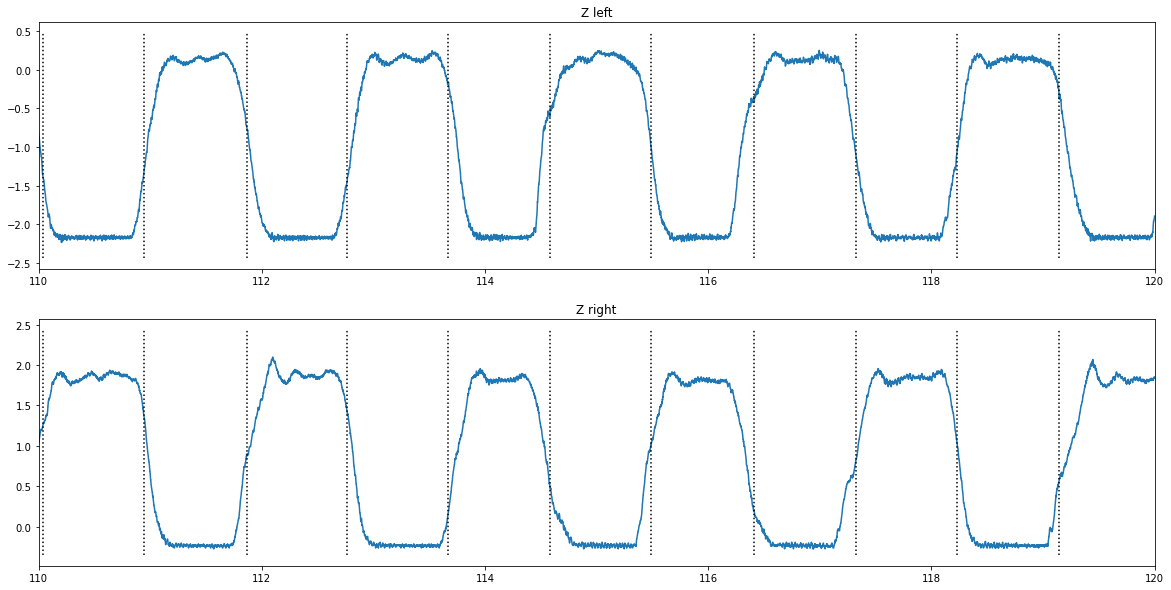

In [14]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(2,1,1)
plt.plot(step['time']/1000,step['z_left'])
plt.title('Z left')
for id,row in sound.iterrows(): 
    plt.plot([row.time,row.time],[step.z_left.min(),step.z_left.max()],'k:')
plt.xlim([110,120])

ax = fig.add_subplot(2,1,2)
plt.plot(step['time']/1000,step['z_right'])
plt.title('Z right')
for id,row in sound.iterrows(): 
    plt.plot([row.time,row.time],[step.z_right.min(),step.z_right.max()],'k:')
plt.xlim([110,120])

